# Advanced Lane Finding Project


## The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Find the chessboard corners from the camera calibration images

20
CPU times: user 4.4 s, sys: 83.3 ms, total: 4.49 s
Wall time: 4.51 s


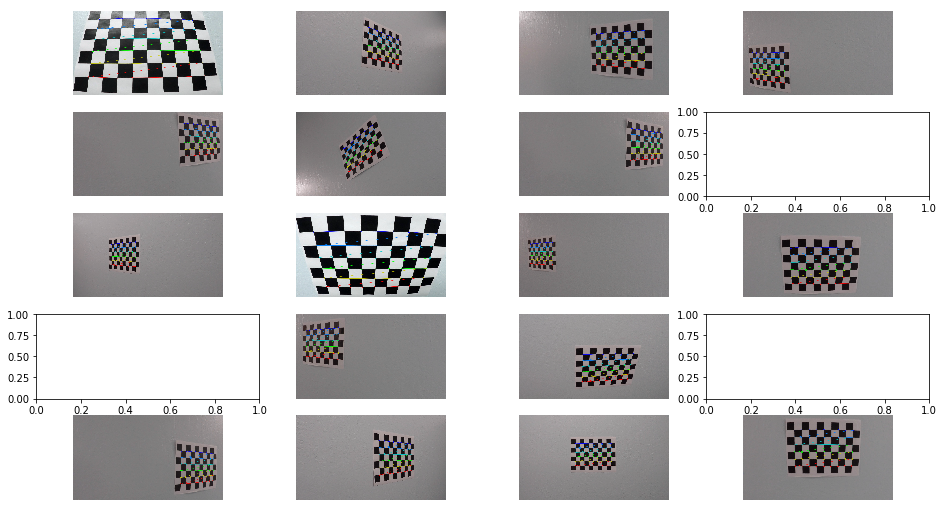

In [4]:
%%time
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

%matplotlib qt



# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

f, ax = plt.subplots(5,4, figsize=(16, 9))
f.subplots_adjust(hspace = .2, wspace=.001)
ax = ax.flatten()

print(len(images))

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)        
        ax[i].imshow(img)
        ax[i].axis('off')

<class 'numpy.ndarray'>


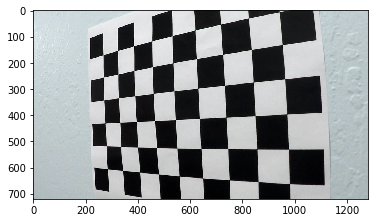

In [3]:
fname = images[7] 
#img = plt.imread(fname)
img = cv2.imread(fname)
print(type(img))
plt.imshow(img)

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

# Write a function to return undistorted image for a input image

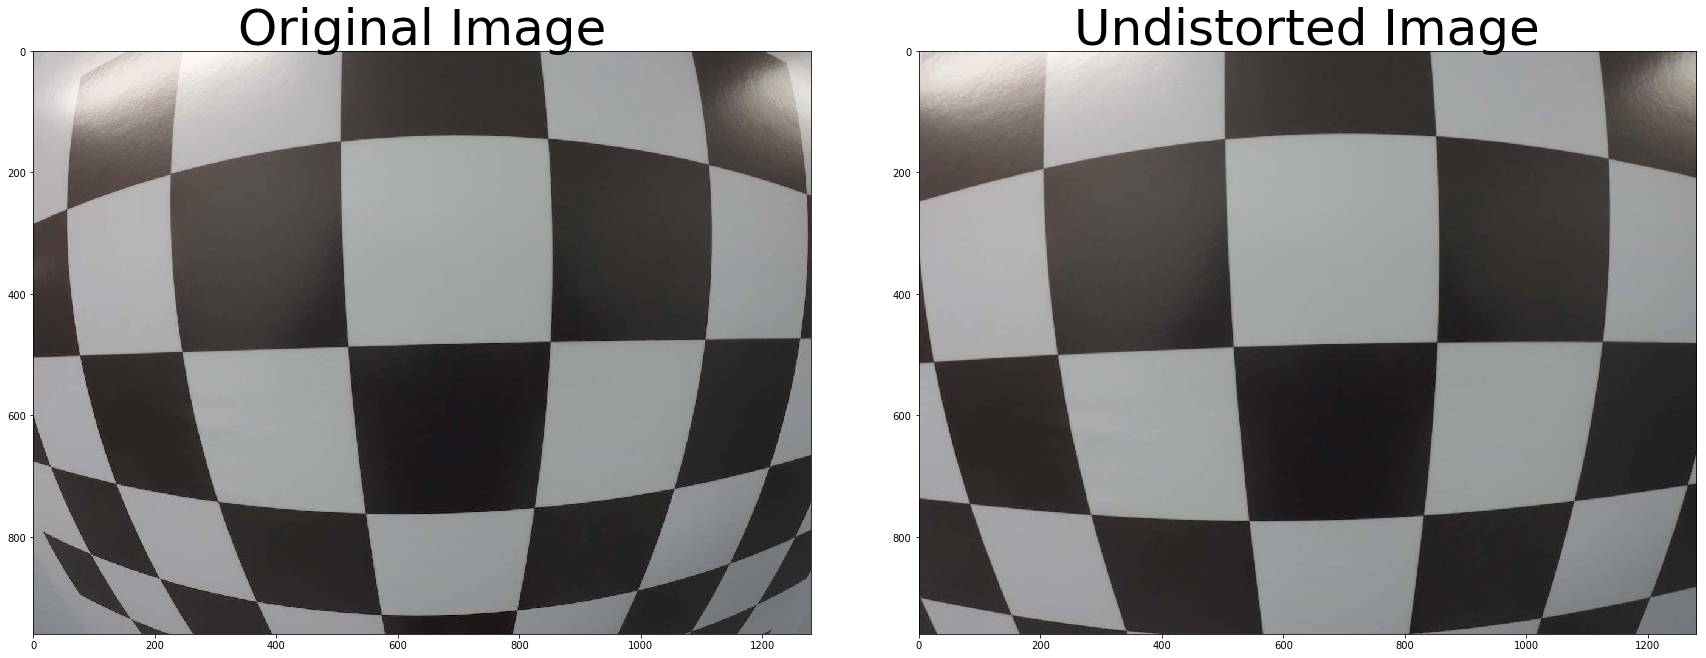

In [5]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undist = np.copy(dst)  # Delete this line
    return undist, mtx, dist


# Read in an image
img = cv2.imread('test_images/test_image.png')
undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Write a function to undistort and unwarp the image

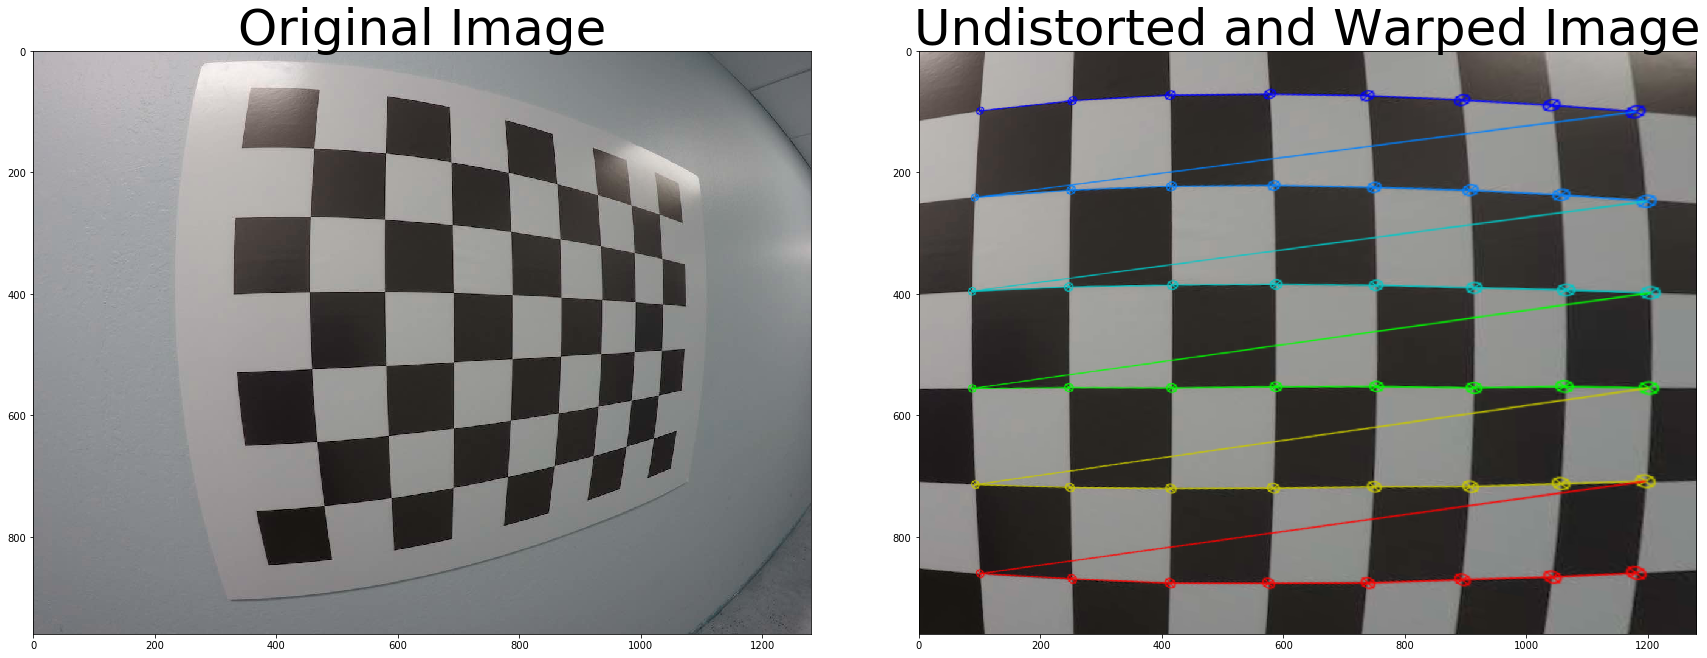

In [6]:
# Read in an image
img = cv2.imread('test_images/test_image2.png')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    offset = 100
    img_size = (gray.shape[1], gray.shape[0])
    
    # 4) If corners found: 
    if ret == True:
        
        # a) draw corners
        img = cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
                
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])             
        #print (corners)
                 
                 
                 
                 
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])                 
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix   
        M = cv2.getPerspectiveTransform(src,dst)

        # e) use cv2.warpPerspective() to warp your image to a top-down view
        img = cv2.warpPerspective(undist,M,img_size)
                 
        
        #delete the next two lines
        M = None
        warped = np.copy(img) 
        
    return warped, M

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Compute thresholded binary image, using color and gradients transforms

(720, 1280)


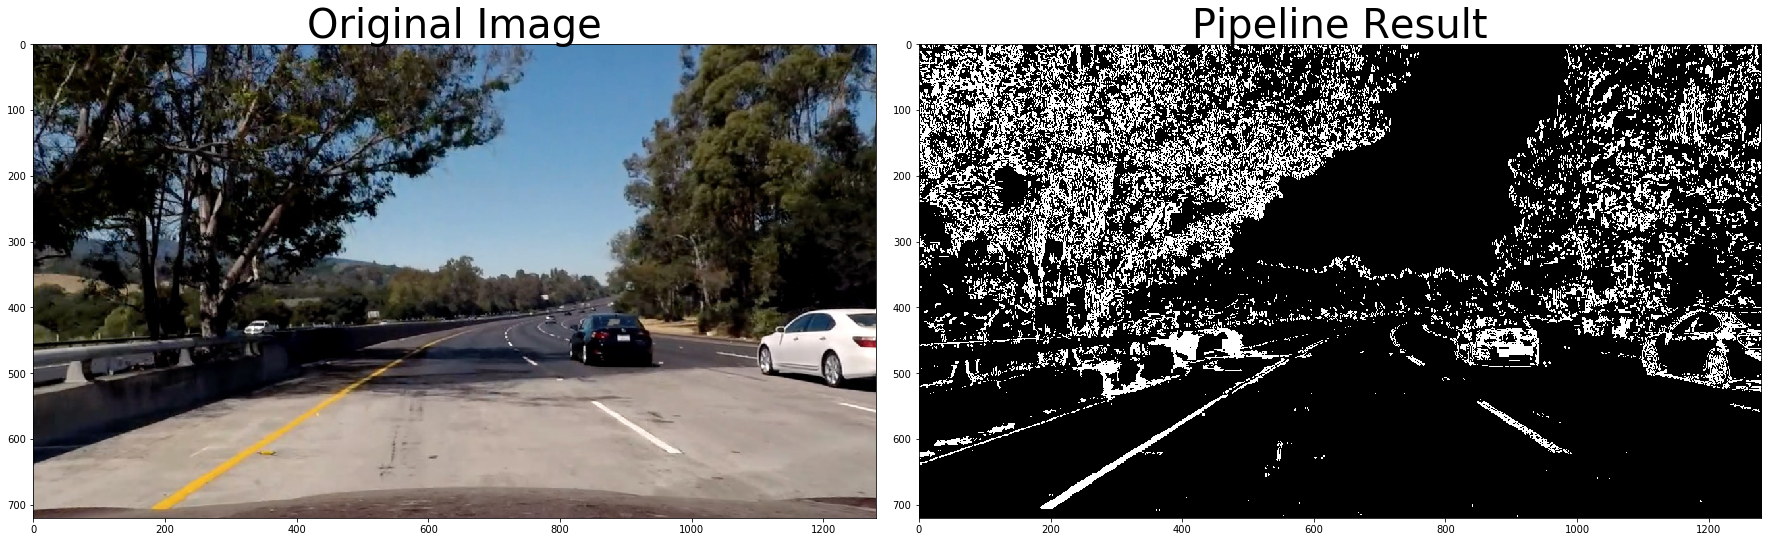

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('test_images/bridge_shadow.jpg')

# This method will apply x gradient threshold and color thresholding.
def color_and_gradient_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    sobel_kernel=15
    mag_thresh = [50, 150]
    dir_thresh=(0.5, 1.0)
    
    #1 Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(s_binary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary
    
result = color_and_gradient_pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Display the dimension of image
print(result.shape)

# Apply Perspective Transform into birds eye view(binary image)

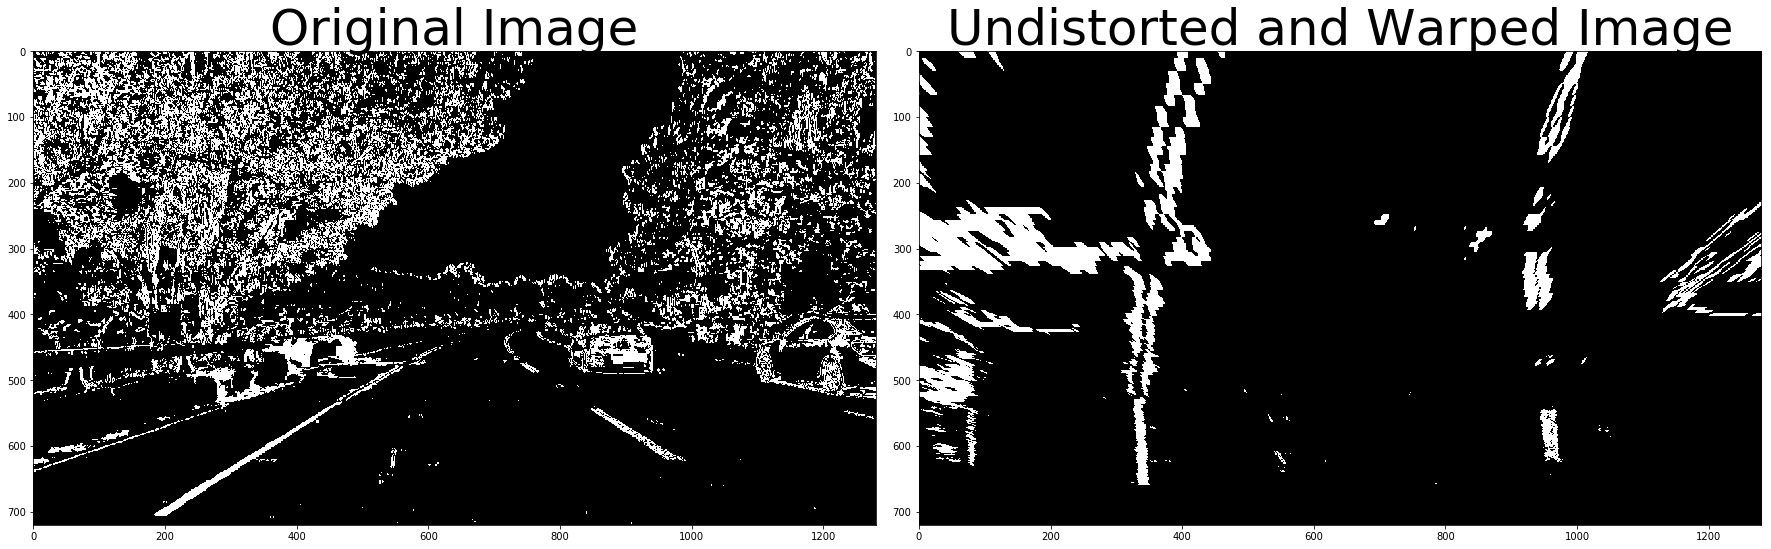

In [8]:
def binary_to_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    offset = 100
    
    img_size = (gray.shape[1], gray.shape[0])
    
    # a) define 4 source points
    src = np.float32([[330,613], [441,546], [952,613], [854,546]])                    
                 
    # b) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[330,613], [330,546], 
                                     [952,613], 
                                     [952,546]])                 
    # c) use cv2.getPerspectiveTransform() to get M, the transform matrix   
    M = cv2.getPerspectiveTransform(src,dst)
    
    # Get inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst,src)

    # d) use cv2.warpPerspective() to warp your image to a top-down view
    img = cv2.warpPerspective(undist,M,img_size)
                 
        
    #delete the next two lines
    M = None
    warped = np.copy(img) 
        
    return warped, M, Minv

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
top_down, perspective_M, Minv = binary_to_unwarp(result, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot a histogram where binary activations occur in image

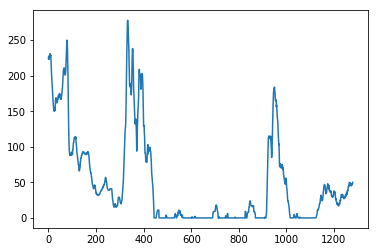

In [9]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    #bottom_half = None
    bottom_half = img[:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    #histogram = None
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(top_down)

# Visualize the resulting histogram
plt.plot(histogram)

# Copy the warped image
binary_warped = np.copy(top_down) 

# Take a histogram along all the columns in the lower half of the image

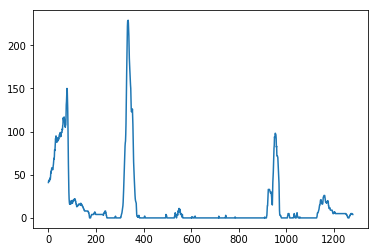

In [10]:
import numpy as np
import matplotlib.pyplot as plt

histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Split the histogram for the two lines

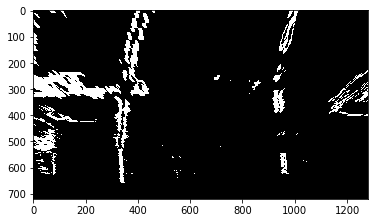

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

plt.imshow(out_img)


# Fit the polynomial thru the two lane lines

np.max(ploty): 719 left_fitx[0]: 429 left_fitx[1]: 428 left_fitx[2]: 428
np.max(ploty): 719 right_fitx[0]: 1003 right_fitx[1]: 1003 right_fitx[2]: 1002
left_fit[0]: 0.0005 left_fit[1]: -0.4342 left_fit[2]: 428.5905
right_fit[0]: 0.0006 right_fit[1]: -0.4332 right_fit[2]: 1003.2309


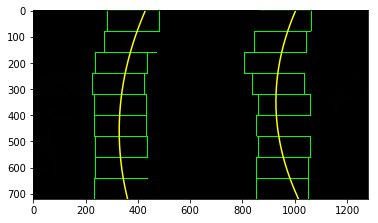

In [12]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    

    
    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit


out_img, ploty, left_fitx, right_fitx, left_fit, right_fit   = fit_polynomial(binary_warped)

print("np.max(ploty): %.0f" % np.max(ploty), "left_fitx[0]: %.0f" % left_fitx[0], "left_fitx[1]: %.0f" % left_fitx[1], "left_fitx[2]: %.0f" % left_fitx[2])

print("np.max(ploty): %.0f" % np.max(ploty), "right_fitx[0]: %.0f" % right_fitx[0], "right_fitx[1]: %.0f" % right_fitx[1], "right_fitx[2]: %.0f" % right_fitx[2])

print( "left_fit[0]: %.4f" % left_fit[0], "left_fit[1]: %.4f" % left_fit[1], "left_fit[2]: %.4f" % left_fit[2])

print( "right_fit[0]: %.4f" % right_fit[0], "right_fit[1]: %.4f" % right_fit[1], "right_fit[2]: %.4f" % right_fit[2])

## Visualization ##
# Colors in the left and right lane regions
#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(out_img)

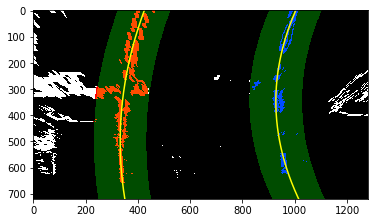

In [13]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
#binary_warped = mpimg.imread('warped_example.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, margin=100):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    #margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
margin = 100
leftx, lefty, rightx, righty = search_around_poly(binary_warped, left_fit, right_fit, margin)

# Fit new polynomials
left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)


## Visualization ##
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
## End visualization steps ##

# View your output
plt.imshow(result)

#  Visualize data in isolation

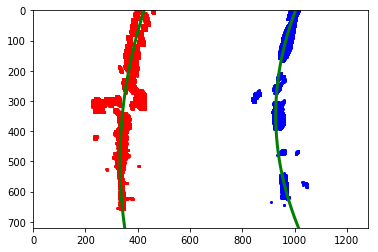

In [14]:
import numpy as np
import matplotlib.pyplot as plt


leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)


#leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

#print(leftx.shape)
#print(rightx.shape)

# Plot up the fake data
mark_size = 2
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Measure Curvature of each lane line

In [15]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''  
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    print("%.0f" % y_eval, "%.4f" % left_fit[0], "%.4f" % left_fit[1])
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)

print(left_curverad, right_curverad)
print("%.2f" % left_curverad, "%.2f" % right_curverad)

719 0.0005 -0.4342
1155.65236927 1073.58457876
1155.65 1073.58


# Conversion from pixel to real-world

In [16]:
# Define conversions in x and y from pixels space to meters
#ym_per_pix = 30/720 # meters per pixel in y dimension
#xm_per_pix = 3.7/700 # meters per pixel in x dimension

ym_per_pix = 3.048/170 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
xm_per_pix = 3.7/650 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters

# Measure curvature of each line in real world

In [17]:
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    h = binary_warped.shape[0]
    
    #print(y_eval)
    
    #factor1 = (ym_per_pix**2)/xm_per_pix
    
    #factor2 = ym_per_pix/xm_per_pix
    
    #denominator1 = np.absolute(2*left_fit[0]*factor1)
    
    #print(factor1, factor2, denominator1)
    
    y_eval = ym_per_pix * y_eval
    
    #print(y_eval)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    #left_curverad = ((1 + (2*left_fit[0]*y_eval*factor1 + left_fit[1]*factor2)**2)**1.5) / denominator1
    #right_curverad = ((1 + (2*right_fit[0]*y_eval*factor1 + right_fit[1]*factor2)**2)**1.5) / denominator1
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = binary_warped.shape[1]/2
        left_boundary = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_boundary = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center = (right_boundary + left_boundary) /2
        center_dist = (car_position - lane_center) * xm_per_pix
    
    return left_curverad, right_curverad, center_dist


# Calculate the radius of curvature in meters for both lane lines
left_curve_rad, right_curve_rad, center_dist = measure_curvature_real(ploty, left_fit, right_fit)



print("%.2f" % left_curve_rad, 'm', "%.2f" % right_curve_rad, 'm')
print("%.2f" % center_dist)
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

1354.25 m 1021.10 m
-0.27


### Project your measurement back down onto the road!

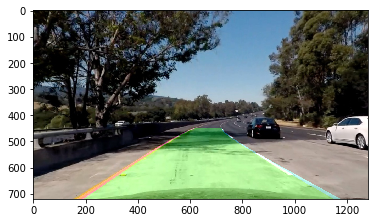

In [18]:
def draw_lane(image, binary_warped, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    h,w = binary_warped.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 

    # Undistort image used above
    undistorted, mtx, dist = cal_undistort(image, objpoints, imgpoints)

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    return result
    
result = draw_lane(image, binary_warped, left_fit, right_fit, Minv)
plt.imshow(result)

### Draw radius of curvature and distance from center of lane onto the image

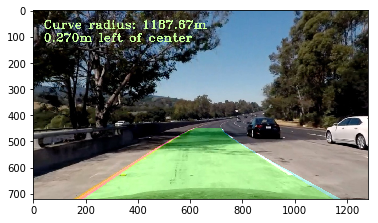

In [19]:
def draw_data(image, curv_rad, center_dist):
    new_img = np.copy(image)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_TRIPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img


data_image = draw_data(result, (left_curve_rad + right_curve_rad)/2, center_dist) 
plt.imshow(data_image)

### Define a class to receive the parameters of each line detection

In [20]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #number of lines to saved
        self.saved_n_lines = 10
        
        
    def add(self, running_fit):
        # check if the newly added line have similar curvature as the previous one
        if running_fit is not None:
                if self.best_fit is not None:
                # if we have a best fit, compare with running fit
                    self.diffs = abs(running_fit-self.best_fit)
                if (self.diffs[0] > 0.001 or \
                   self.diffs[1] > 1.0 or \
                   self.diffs[2] > 100.) and \
                   len(self.current_fit) > 0:
                    self.detected = False
                else:
                    self.detected = True
                    self.current_fit.append(running_fit)
                    if len(self.current_fit) > self.saved_n_lines:
                        # only keep newest n
                        self.current_fit = self.current_fit[len(self.current_fit) - self.saved_n_lines:]
                    #print('self.current_fit  size', len(self.current_fit))
                    self.best_fit = np.average(self.current_fit, axis=0)
        # if not found, use the latest saved line
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # remove last line
                self.current_fit = self.current_fit[:len(self.current_fit) - 1]
                # update best_fit as average of lines in current_fit
                self.best_fit = np.average(self.current_fit, axis=0)

### Define Image Processing Pipeline

In [21]:
def display_input_output_images(input_image, output_image, titles, cmap1=None, cmap2=None):
    # plot binary vs undistorted image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    
    ax1.imshow(input_image, cmap=cmap1)
    ax1.set_title(titles[0], fontsize=40)

    ax2.imshow(output_image, cmap=cmap2)
    ax2.set_title(titles[1], fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

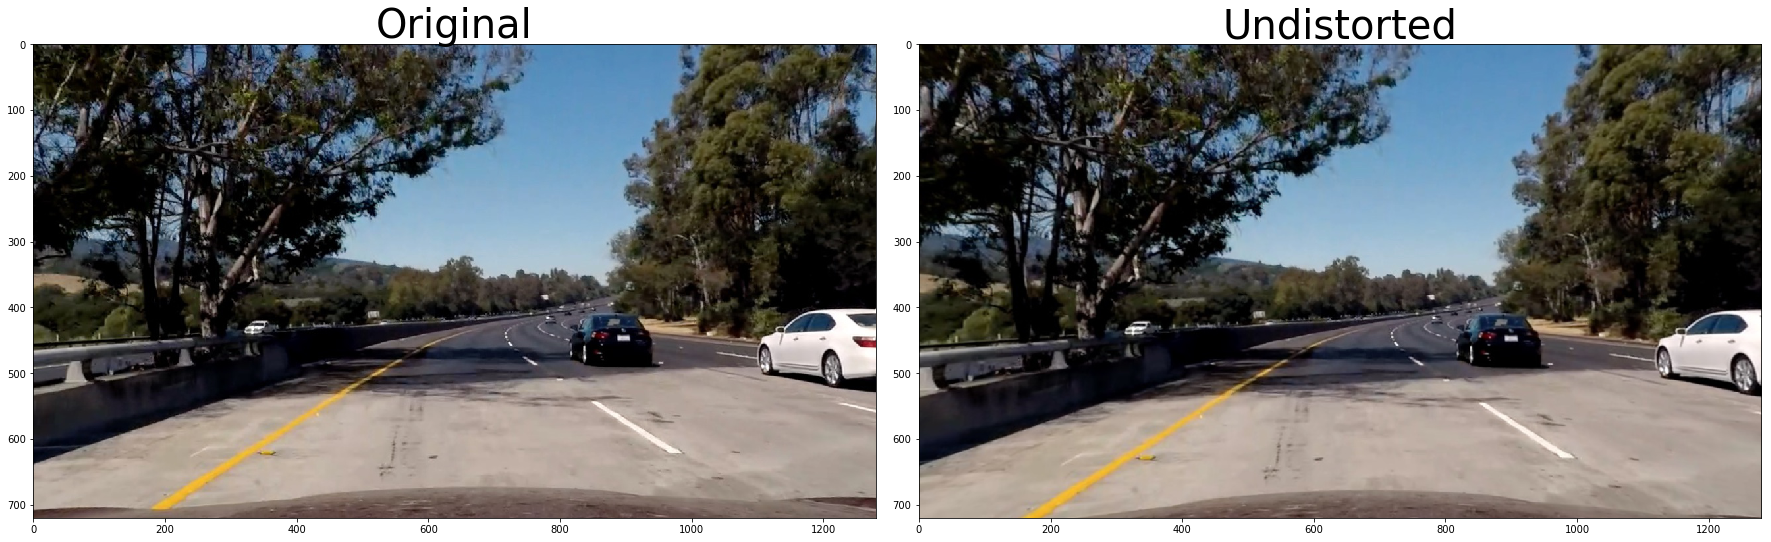

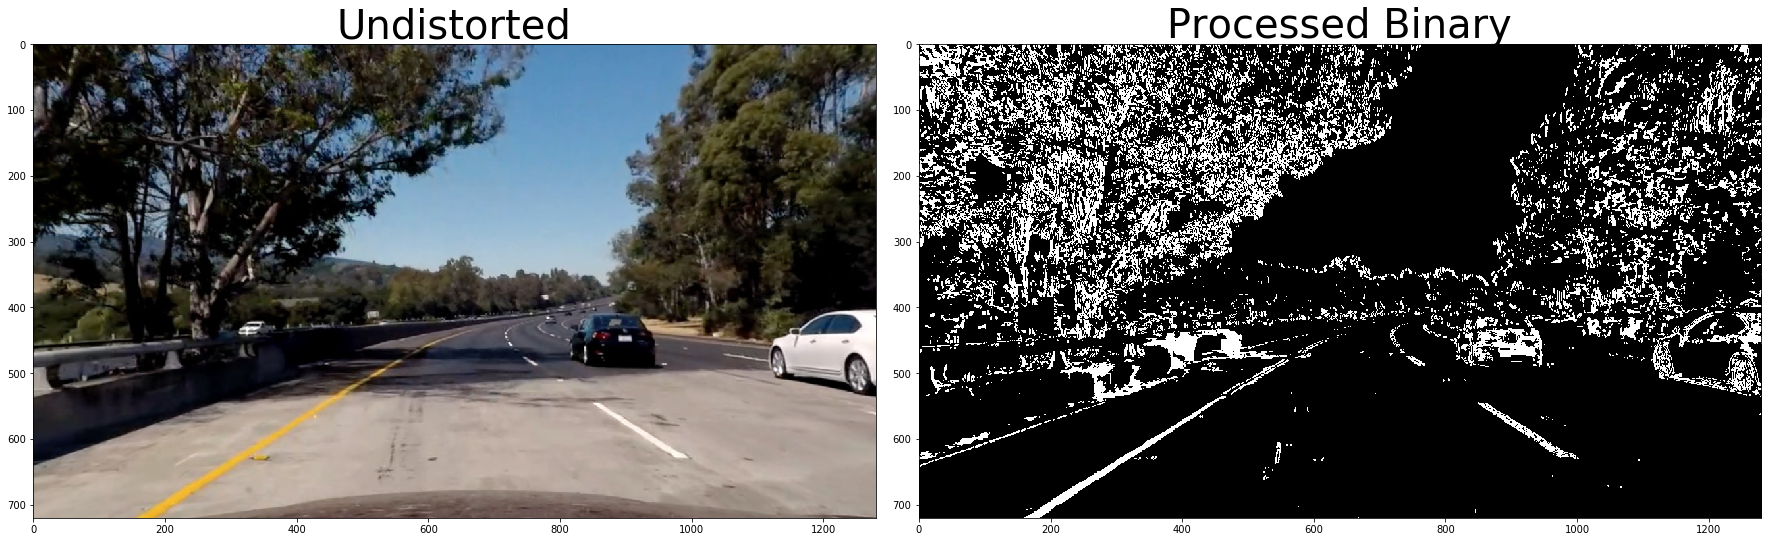

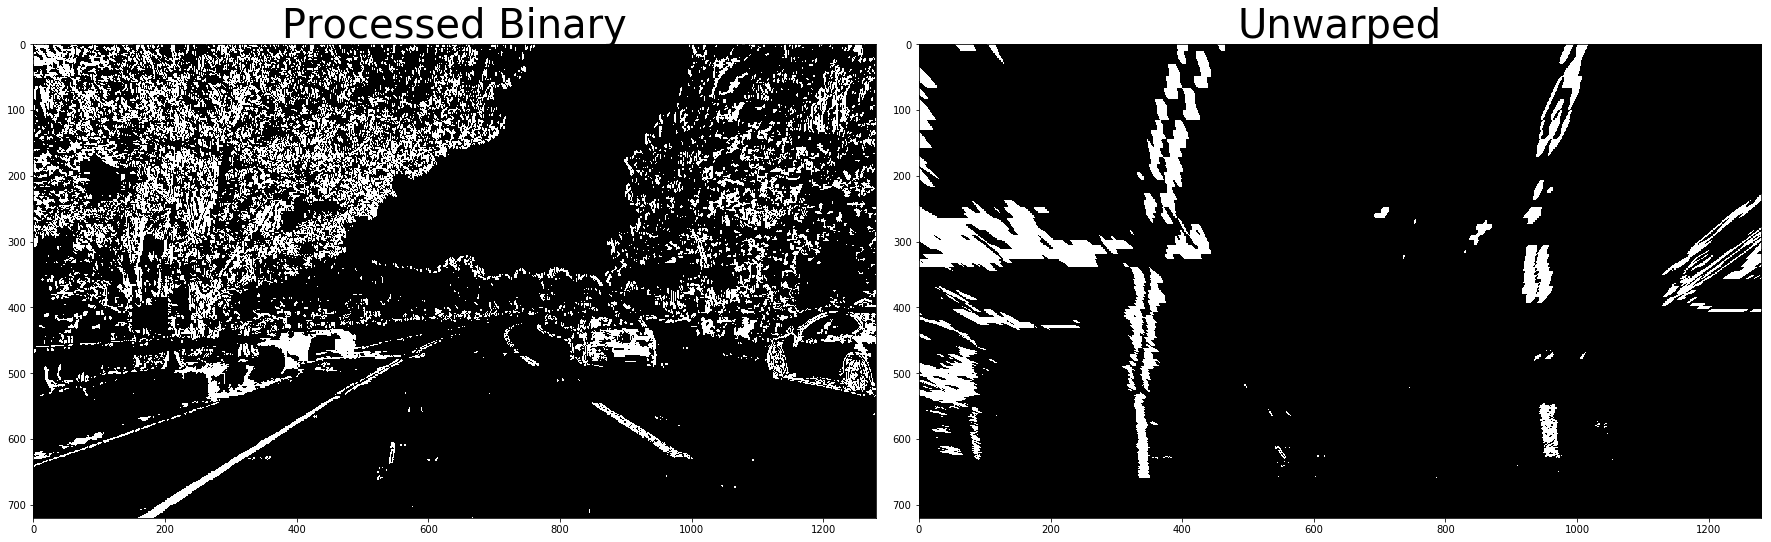

In [22]:
def process_image(image):
    current_image = np.copy(image)
    
    # convert to undistorted image using objpoints and imgpoints
    undist, mtx, dist = cal_undistort(current_image, objpoints, imgpoints)
    
    # plot binary vs undistorted image
    display_input_output_images(current_image, undist, ['Original','Undistorted'])
    
    # convert to binary using color and gradient processing
    binary = color_and_gradient_pipeline(undist)
    
    # plot image vs binary
    display_input_output_images(undist, binary,  ['Undistorted','Processed Binary'], cmap2='gray')
        
    # convert umwarped image using undistorted image
    top_down, perspective_M, Minv = binary_to_unwarp(binary, nx, ny, mtx, dist)
    
    # plot undistorted vs unwarped image
    display_input_output_images(binary, top_down, ['Processed Binary','Unwarped'], cmap1='gray', cmap2='gray')
    
    
image = mpimg.imread('test_images/bridge_shadow.jpg')

process_image(image)        
    

In [23]:
# If running right and left lines are not detected, use last fitting line
def use_last_fit(binary_warped, best_fit_left, best_fit_right):
    nonzero_idx = binary_warped.nonzero()
    nonzeroy_idx = np.array(nonzero_idx[0])
    nonzerox_idx = np.array(nonzero_idx[1])
    margin = 100
    left_line_idx = ((nonzerox_idx > (best_fit_left[0]*(nonzeroy_idx**2) + best_fit_left[1]*nonzeroy_idx + best_fit_left[2] - margin)) & 
                      (nonzerox_idx < (best_fit_left[0]*(nonzeroy_idx**2) + best_fit_left[1]*nonzeroy_idx + best_fit_left[2] + margin))) 
    right_line_idx = ((nonzerox_idx > (best_fit_right[0]*(nonzeroy_idx**2) + best_fit_right[1]*nonzeroy_idx + best_fit_right[2] - margin)) & 
                       (nonzerox_idx < (best_fit_right[0]*(nonzeroy_idx**2) + best_fit_right[1]*nonzeroy_idx + best_fit_right[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox_idx[left_line_idx]
    lefty = nonzeroy_idx[left_line_idx] 
    rightx = nonzerox_idx[right_line_idx]
    righty = nonzeroy_idx[right_line_idx]
    
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_line_idx, right_line_idx

In [24]:
def image_pipeline(image):
    current_image = np.copy(image)
    
    # convert to undistorted image using objpoints and imgpoints
    undist, mtx, dist = cal_undistort(current_image, objpoints, imgpoints)
    
    # convert to binary using color and gradient processing
    binary = color_and_gradient_pipeline(undist)
        
    # convert unwarped image using undistorted image
    top_down_image, perspective_M, Minv = binary_to_unwarp(binary, nx, ny, mtx, dist)
    
    #plt.imshow(top_down_image)
    
    # if both left and right lines were detected in previous frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not (left_line.detected and  right_line.detected):
        out_img, ploty, left_fitx, right_fitx, left_fit, right_fit  = fit_polynomial(top_down_image)
    else:
        left_fit, right_fit, left_line_idx, right_line_idx = use_last_fit(top_down_image, left_line.best_fit, right_line.best_fit)
        
        
    #out_img, ploty, left_fitx, right_fitx, left_fit, right_fit  = fit_polynomial(top_down_image)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    #if left_fit is not None and right_fit is not None:
        
    # calculate x-intercept (bottom of image, x=image_height) for fits
    #h = current_image.shape[0]
    #left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    #right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    #x_int_diff = abs(right_fit_x_int - left_fit_x_int)
    # if abs(550 - x_int_diff) > 100:
    #    left_fit = None
    #    right_fit = None
        
    #print('left_fit:', left_fit, 'right_fit:', right_fit)
            
    left_line.add(left_fit)
    right_line.add(right_fit)
    
    #print('left_line.best_fit:', left_line.best_fit, 'right_line.best_fit:', right_line.best_fit)
    
    # draw the current best fit if it exists
    if left_line.best_fit is not None and right_line.best_fit is not None:
        
        image_lane = draw_lane(current_image, top_down_image, left_line.best_fit, right_line.best_fit, Minv)
        
        ploty = np.linspace(0, top_down_image.shape[0]-1, top_down_image.shape[0] )
        
        left_curve_rad, right_curve_rad, center_dist = measure_curvature_real(ploty, left_line.best_fit, right_line.best_fit)
        
        pipeline_image = draw_data(image_lane, (left_curve_rad + right_curve_rad)/2, center_dist)   
    else:
        pipeline_image = current_image
    
    return pipeline_image

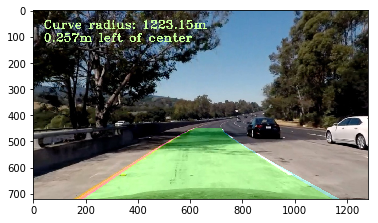

In [25]:
left_line = Line()
right_line = Line()
image = mpimg.imread('test_images/bridge_shadow.jpg')
output = image_pipeline(image)
plt.imshow(output)

### Process Project Video

In [26]:
from moviepy.editor import VideoFileClip
left_line = Line()
right_line = Line()
project_video_output = 'project_video_output.mp4'
project_video_input = VideoFileClip('project_video.mp4')
processed_video = project_video_input.fl_image(image_pipeline)
%time processed_video.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [44:26<00:02,  2.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 41min 55s, sys: 11.4 s, total: 42min 7s
Wall time: 44min 29s


In [27]:
from moviepy.editor import VideoFileClip
left_line = Line()
right_line = Line()
project_video_output = 'challenge_video_output.mp4'
project_video_input = VideoFileClip('challenge_video.mp4')
processed_video = project_video_input.fl_image(image_pipeline)
%time processed_video.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [17:05<00:00,  2.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 16min 11s, sys: 5 s, total: 16min 16s
Wall time: 17min 8s
